In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt


In [21]:
def label_img(name, folder):
    if folder!= 'data/pictures/data_vlad':
        word_label = list(name)[0]
    else:
        word_label = list(name)[-5]
    return word_label

In [22]:
!ls data/

1.1.png  kek.txt  pictures


In [23]:
IMG_SIZE = 28
import random
DIR = ['data/pictures/data_rus', 'data/pictures/data_yar', 'data/pictures/data_max', 'data/pictures/data_vlad']
def load_training_data():
    k=0
    train_data = []
    labels = []
    for folder in DIR:
        for img in os.listdir(str(folder)):
            label = label_img(img, folder)
            path = os.path.join(str(folder), img)
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            k+=1
#             img.save('pictures/lol/niga'+str(k)+'.jpg')
            
            train_data.append(np.array(img))
            labels.append(label)
            # Basic Data Augmentation - Horizontal Flipping and Vertical Flipping
            flip_img = Image.open(path)
            flip_img = flip_img.convert('L')
            flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            flip_img1 = np.array(flip_img)
#             flip_img = np.flip(flip_img1,axis=1)
#             train_data.append(flip_img)
#             labels.append(label)
            flip_img = np.flip(flip_img1,axis=0)
            train_data.append(flip_img)
            labels.append(label)

    #     random.shuffle(train_data)
    train_data = np.array(train_data)
    return train_data, labels
data, labels = load_training_data()

In [24]:
def augment_images(data, labels, copies = 1, rotation=True, shear=True, shift=True, zoom=True):
    augmented_data = []
    augmented_labels = []
    
    for i in range (0, np.shape(labels)[0]):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        
        for j in range(1, copies):            
            img = data[i]
            lbl = labels[i]
                        
            if (rotation):
                img = tf.contrib.keras.preprocessing.image.random_rotation(img, 15, row_axis=0, col_axis=1, channel_axis=2)
            if (shear):
                img = tf.contrib.keras.preprocessing.image.random_shear(img, 0.1, row_axis=0, col_axis=1, channel_axis=2)
            if (shift):
                img = tf.contrib.keras.preprocessing.image.random_shift(img, 0.15, 0.15, row_axis=0, col_axis=1, channel_axis=2)
            if (zoom):
                img = tf.contrib.keras.preprocessing.image.random_zoom(img, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)
            
            augmented_data.append(img)
            augmented_labels.append(lbl)
    
    return np.array(augmented_data), np.array(augmented_labels)

In [25]:
X = data.reshape(-1, 28, 28, 1).astype(np.float32)
X /= 255.0
# X_test = test_data.values.reshape(-1, image_size, image_size, num_channels).astype(np.float32)


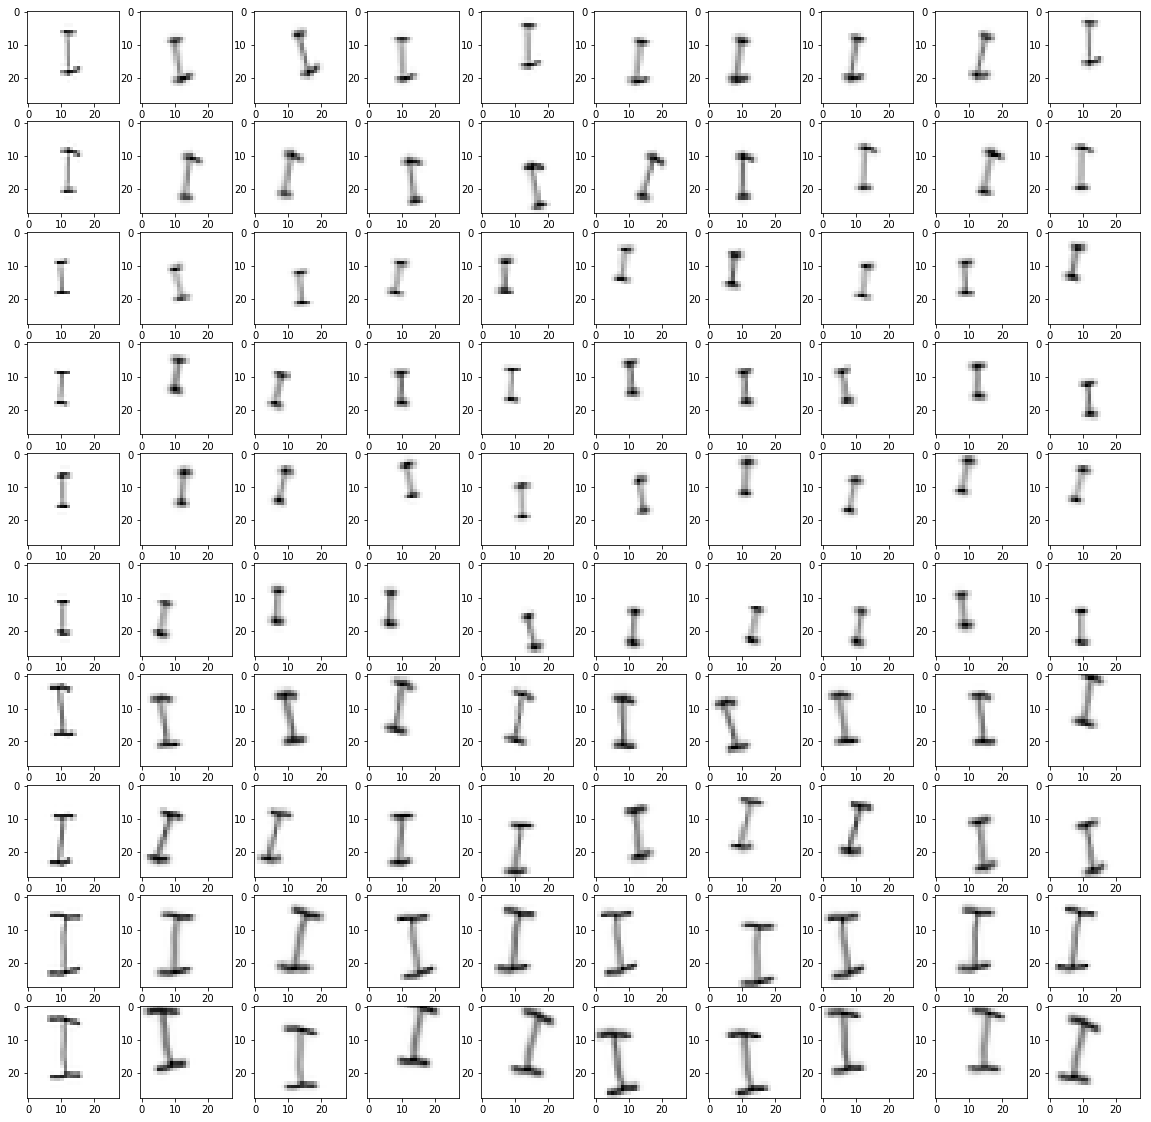

In [26]:
x = X[:10]
y = labels[:10]
x, y = augment_images(x, y, copies=10,zoom=False)

plt.figure(figsize=(20,20))
for i in range(len(x)):
    plt.subplot(10,10,1+i)
    plt.imshow(x[i].reshape(28,28), cmap='gist_gray')
    


In [27]:
data_, labels_ = augment_images(X, labels, copies=10,zoom=False)

In [28]:
data_.shape, labels_.shape

((8040, 28, 28, 1), (8040,))

In [29]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
labels_ = pd.get_dummies(labels_).values


In [30]:
print(len(data_),'==', len(labels_))

8040 == 8040


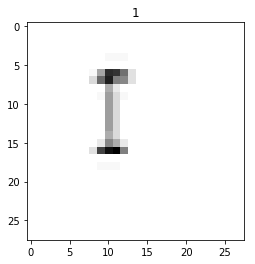

In [31]:
k=4
plt.title(labels[k])
plt.imshow(data[k], cmap = 'gist_gray')


In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train_data,test_data,train_labels, test_labels = train_test_split(data_,labels_,test_size=0.2)

In [34]:
# train_labels = np.array(list(map(lambda x:int(x),train_labels)))
# test_labels = np.array(list(map(lambda x:int(x),test_labels)))

In [35]:
X_train, X_valid, Y_train, Y_valid = train_test_split(data_,labels_,test_size=0.2)
# Y_train = np.array(list(map(lambda x:int(x),Y_train)))
# Y_vlaid = np.array(list(map(lambda x:int(x),Y_valid)))

In [36]:
image_size = 28
num_channels = 1
num_labels = 8
graph = tf.Graph()
with graph.as_default():
    
    X = tf.placeholder(tf.float32, shape=(None,image_size,image_size,num_channels))
    Y_ = tf.placeholder(tf.float32, shape=(None,num_labels))
    tf_step = tf.placeholder(tf.float32)
    tf_pkeep = tf.placeholder(tf.float32)
    
    tf_test_dataset = tf.constant(X_valid)
    
    K = 6  # first convolutional layer output depth
    L = 12  # second convolutional layer output depth
    M = 24  # third convolutional layer output depth
    N = 200  # fully connected layer

    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    W5 = tf.Variable(tf.truncated_normal([N, 8], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [8]))
    
    def model(data):
        Y1 = tf.nn.relu(tf.nn.conv2d(data, W1, strides=[1, 1, 1, 1], padding='SAME') + B1) # output is 28x28
        Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, 2, 2, 1], padding='SAME') + B2) # output is 14x14
        Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, 2, 2, 1], padding='SAME') + B3)  # output is 7x7
        Y3_flat = tf.reshape(Y3, shape=[-1, 7 * 7 * M])
        Y4 = tf.nn.dropout(tf.nn.relu(tf.matmul(Y3_flat, W4) + B4), tf_pkeep)
        return tf.matmul(Y4, W5) + B5
    
    logits = model(X)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y_))*100
    
    lr = 0.0001 + tf.train.exponential_decay(0.005, tf_step, 2000, 1/math.e)
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)   
    
    Y = tf.nn.softmax(logits)
    Y_test = tf.nn.softmax(model(tf_test_dataset))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1)), tf.float32))

In [37]:
num_steps = 30001
batch_size = 100

acc = []
costs = []
rates = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for step in range(num_steps):
        offset = (step * batch_size) % (Y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = Y_train[offset:(offset + batch_size), :]
        
        if (step % 100 == 0):
            a, l, r = session.run([accuracy, loss, lr], feed_dict={
                X : batch_data, 
                Y_ : batch_labels,
                tf_pkeep : 1.0,
                tf_step : step
            })
            print(str(step) + ": accuracy: " + str(a) + " loss: " + str(l) + " (lr:" + str(r) + ")")
        
        if (step % 500 == 0):
            a, l = session.run([accuracy, loss], feed_dict={
                X : X_valid, 
                Y_ : Y_valid,
                tf_pkeep : 1.0
            })
            print(str(step) + ": validation accuracy: " + str(a) + " validation loss: " + str(l))        
        
        _, a, l, r = session.run([optimizer, accuracy, loss, lr], feed_dict={
            X : batch_data, 
            Y_: batch_labels,
            tf_pkeep : 0.75,
            tf_step : step
        })
        
        if (step % 10 == 0):
            costs.append(l)
            rates.append(r)
            acc.append(a)
            

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at <ipython-input-36-255146dc8c82>:31)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, Variable/read)]]

Caused by op 'Conv2D', defined at:
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-255146dc8c82>", line 38, in <module>
    logits = model(X)
  File "<ipython-input-36-255146dc8c82>", line 31, in model
    Y1 = tf.nn.relu(tf.nn.conv2d(data, W1, strides=[1, 1, 1, 1], padding='SAME') + B1) # output is 28x28
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at <ipython-input-36-255146dc8c82>:31)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, Variable/read)]]


In [38]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 150, 150, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=8)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [39]:
train_data = train_data/np.float32(255)

In [40]:
test_data = test_data/np.float32(255)

In [41]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="dataset")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'dataset', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f174488b1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [42]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [43]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.


ValueError: Dimension size must be evenly divisible by 22500 but is 78400 for 'Reshape' (op: 'Reshape') with input shapes: [100,28,28,1], [4] and with input tensors computed as partial shapes: input[1] = [?,150,150,1].

In [44]:
mnist_classifier.train(input_fn=train_input_fn, steps=1000)


INFO:tensorflow:Calling model_fn.


ValueError: Dimension size must be evenly divisible by 22500 but is 78400 for 'Reshape' (op: 'Reshape') with input shapes: [100,28,28,1], [4] and with input tensors computed as partial shapes: input[1] = [?,150,150,1].

In [223]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.


TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

In [86]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
train_data, test_data = train_data/255.0, test_data/255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(150, 150)),
  tf.keras.layers.Dense(2048, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(input_shape=(32, 32)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
 
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.fit(train_data, train_labels, epochs=20)
# model.evaluate(test_data, test_labels)

In [87]:
model.fit(train_data, train_labels, epochs=20)

Epoch 1/20
192/594 [========>.....................] - ETA: 18s - loss: 2.2963 - acc: 0.1406

KeyboardInterrupt: 

In [90]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [95]:
set(train_labels)

{1, 2, 3, 4, 5, 6, 7, 8, 9}